In [1]:
import boto3
import argparse

In [2]:
# # Optional: Set AWS credentials
# # To use this cell, comment out all lines

# # Alternatively, if your AWS credential is defined in ~/.aws/credentials
# # you can use `profile_name` parameter in submit_job() function

# import os, getpass
# os.environ["AWS_ACCESS_KEY_ID"] = getpass.getpass("Enter aws access key ID ")
# os.environ["AWS_SECRET_ACCESS_KEY"] = getpass.getpass("Enter aws secret access key ")
# os.environ["AWS_DEFAULT_REGION"] = input("Enter aws default region ")

In [2]:
def submit_job(lr:float, momentum:float, epochs:int, profile_name=None):
    """
    Submit a job to AWS Batch queue.
    Parameters
    ----------
    lr: float
        Learning rate
    momentum: float
    epochs: float
        Maximum number of training epochs
    profile_name: str
        The profile name used to access AWS.
        The profile is defined in `~/.aws/credentials`.
    """
    if profile_name is None:
        session = boto3.Session()
    else:
        session = boto3.Session(profile_name=profile_name)
    client = session.client("batch")
    
    title = "lr" + str(lr).replace(".", "") + "_m" + str(momentum).replace(".", "")
    resp = client.submit_job(
        jobName=title,
        jobQueue="SimpleBatchjob-queue",
        jobDefinition="SimpleBatchjob-definition",
        containerOverrides={
            "command": ["--lr", str(lr),
                        "--momentum", str(momentum),
                        "--epochs", str(epochs),
                        "--uploadS3", "true"]
        }
    )
    print("Job submitted!")
    print("job name", resp["jobName"], "job ID", resp["jobId"])

### Let's submit a single job

In [3]:
submit_job(0.01, 0.1, 100)

Job submitted!
job name lr001_m01 job ID f828e092-2f89-4a53-baaa-d43506c0c270


### Let's download the learning result and make plots

In [5]:
import pandas as pd
import io
from matplotlib import pyplot as plt

In [6]:
def read_table_from_s3(bucket_name, key, profile_name=None):
    if profile_name is None:
        session = boto3.Session()
    else:
        session = boto3.Session(profile_name=profile_name)
    s3 = session.resource("s3")
    bucket = s3.Bucket(bucket_name)
    
    obj = bucket.Object(key).get().get("Body")
    df = pd.read_csv(obj)
    
    return df

In [7]:
#### Remember to replace bucket name with your own name! ####
bucket_name = "simplebatch-bucket43879c71-mbqaltx441fu"

df = read_table_from_s3(
    bucket_name,
    "metrics_lr0.0100_m0.1000.csv"
)

In [8]:
df

,train_loss,val_loss,val_accuracy
0,0.606683,0.232050,93.183333
1,0.308607,0.178057,94.650000
2,0.252555,0.151265,95.550000
3,0.211590,0.124155,96.375000
4,0.185905,0.104406,97.008333
...,...,...,...
95,0.012469,0.042689,99.125000
96,0.011955,0.042282,99.125000
97,0.011154,0.043061,99.100000
98,0.011754,0.042295,99.108333


Best loss: 0.0377041386226968
Best loss epoch: 37
Best accuracy: 99.15833333333332
Best accuracy epoch: 67


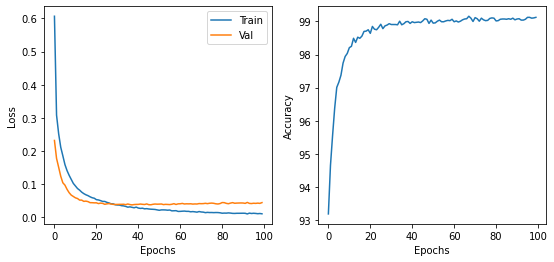

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4))
x = [i for i in range(df.shape[0])]
ax1.plot(x, df["train_loss"], label="Train")
ax1.plot(x, df["val_loss"], label="Val")
ax2.plot(x, df["val_accuracy"])

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")

print("Best loss:", df["val_loss"].min())
print("Best loss epoch:", df["val_loss"].argmin())
print("Best accuracy:", df["val_accuracy"].max())
print("Best accuracy epoch:", df["val_accuracy"].argmax())